In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import fastai 
from fastai.vision import *

In [5]:
import numpy as np
import datetime
import os, sys

In [6]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, imsave

In [7]:
torch.cuda.empty_cache()

In [8]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"

In [9]:
print('Using device:', DEVICE)
print()

#Additional Info when using cuda
if hasattr(DEVICE, 'type') and DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
image_size=248
batch_size = 10

In [11]:
# could not broadcast input array from shape (500,5000) into shape (500,2500)
# could not broadcast input array from shape (250,1250) into shape (250,2500)
# could not broadcast input array from shape (250,1250) into shape (250,2500)

def get_sample_image(G, n_noise):
    """
        save sample 25 images
    """
    z = torch.randn(25, n_noise).to(DEVICE)
    # print(z[0][0:100])
    y_hat = G(z).view(25, image_size, image_size)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([image_size * 5, image_size * 5])
    for j in range(5):
        # b = np.concatenate([np.where(x > 0.5, 1, 0) for x in result[j*5:(j+1)*5]], axis=-1)
        b = np.concatenate([x for x in result[j*5:(j+1)*5]], axis=-1)
        img[j*image_size:(j+1)*image_size] = b
    return img

In [12]:
#plt.figure(figsize = (15,15))
#plt.imshow(get_sample_image(G, n_noise), cmap='gray')

In [13]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=image_size ** 2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            # nn.Linear(input_size, 256),            
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            # nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            # nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [14]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=batch_size, num_classes=image_size ** 2):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
            # nn.Hardtanh()
            # nn.Sigmoid(),
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, image_size, image_size)
        return y_

In [15]:
n_noise = 100

In [16]:
torch.cuda.empty_cache()
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [17]:
# TODO: The random affine doesn't rotate, but I need to make sure rotate doesn't introduce padding.
# Fastai does a much better job of it. For now, use white padding.
def load_dataset():
    data_path = 'geo-images-square'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.RandomResizedCrop(248, scale=(0.8, 1.), ratio=(1., 1.)),
            # tochvision.transforms.RandomAffine(0, scale=(1.,1.8), fillcolor=255, shear=None),
            torchvision.transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return train_loader

Batch shape: (10, 1, 248, 248)


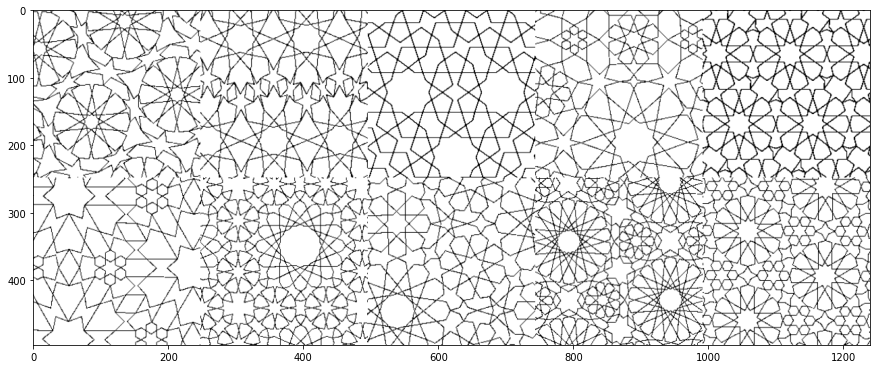

In [23]:
# Show a batch of sample images.
imgs, _ = next(iter(load_dataset()))
print('Batch shape:',imgs.numpy().shape)

img = np.zeros([image_size * 2, image_size * 5])
for j in range(2):
    # b = np.concatenate([np.where(x > 0.5, 1, 0) for x in result[j*5:(j+1)*5]], axis=-1)
    b = np.concatenate([x for x in imgs[j*5:(j+1)*5]], axis=-1)
    img[j*image_size:(j+1)*image_size] = b


# out = torchvision.utils.make_grid(imgs[0])
plt.figure(figsize = (15,15))
plt.imshow(img, cmap='gray')
#plt.show()


In [24]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [25]:
max_epoch = 5000 # need more than 10 epochs for training generator
n_critic = 1 # for training more k steps about Discriminator

In [26]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [27]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [28]:
step = 0

In [29]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(load_dataset()):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
                
        if step % 100 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 500 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/5000, Step: 0, D Loss: 1.3849226236343384, G Loss: 1.0135252475738525
Epoch: 16/5000, Step: 100, D Loss: 1.2161998748779297, G Loss: 0.6852700114250183
Epoch: 33/5000, Step: 200, D Loss: 1.410524606704712, G Loss: 0.5862157940864563
Epoch: 50/5000, Step: 300, D Loss: 1.2811658382415771, G Loss: 0.6995952725410461
Epoch: 66/5000, Step: 400, D Loss: 1.3410686254501343, G Loss: 0.7236515879631042
Epoch: 83/5000, Step: 500, D Loss: 1.4256114959716797, G Loss: 0.5473496317863464
Epoch: 100/5000, Step: 600, D Loss: 1.3523911237716675, G Loss: 0.4907829165458679
Epoch: 116/5000, Step: 700, D Loss: 1.9457182884216309, G Loss: 0.15921497344970703
Epoch: 133/5000, Step: 800, D Loss: 1.5964386463165283, G Loss: 1.3961365222930908
Epoch: 150/5000, Step: 900, D Loss: 1.383239507675171, G Loss: 0.8130272626876831
Epoch: 166/5000, Step: 1000, D Loss: 1.3360037803649902, G Loss: 0.7664254307746887
Epoch: 183/5000, Step: 1100, D Loss: 1.3948593139648438, G Loss: 0.7401291131973267
Epoch: 200/5

Epoch: 1633/5000, Step: 9800, D Loss: 1.403885841369629, G Loss: 0.6485501527786255
Epoch: 1650/5000, Step: 9900, D Loss: 1.3861379623413086, G Loss: 0.6972114443778992
Epoch: 1666/5000, Step: 10000, D Loss: 1.3819124698638916, G Loss: 0.6241949200630188
Epoch: 1683/5000, Step: 10100, D Loss: 1.388519287109375, G Loss: 0.735840916633606
Epoch: 1700/5000, Step: 10200, D Loss: 1.3883862495422363, G Loss: 0.6753911972045898
Epoch: 1716/5000, Step: 10300, D Loss: 1.3863943815231323, G Loss: 0.7464879751205444
Epoch: 1733/5000, Step: 10400, D Loss: 1.3973108530044556, G Loss: 0.7704614996910095
Epoch: 1750/5000, Step: 10500, D Loss: 1.3860172033309937, G Loss: 0.698934018611908
Epoch: 1766/5000, Step: 10600, D Loss: 1.3806746006011963, G Loss: 0.633623480796814
Epoch: 1783/5000, Step: 10700, D Loss: 1.386737585067749, G Loss: 0.7271407842636108
Epoch: 1800/5000, Step: 10800, D Loss: 1.3779970407485962, G Loss: 0.6606875658035278
Epoch: 1816/5000, Step: 10900, D Loss: 1.3878741264343262, G L

KeyboardInterrupt: 

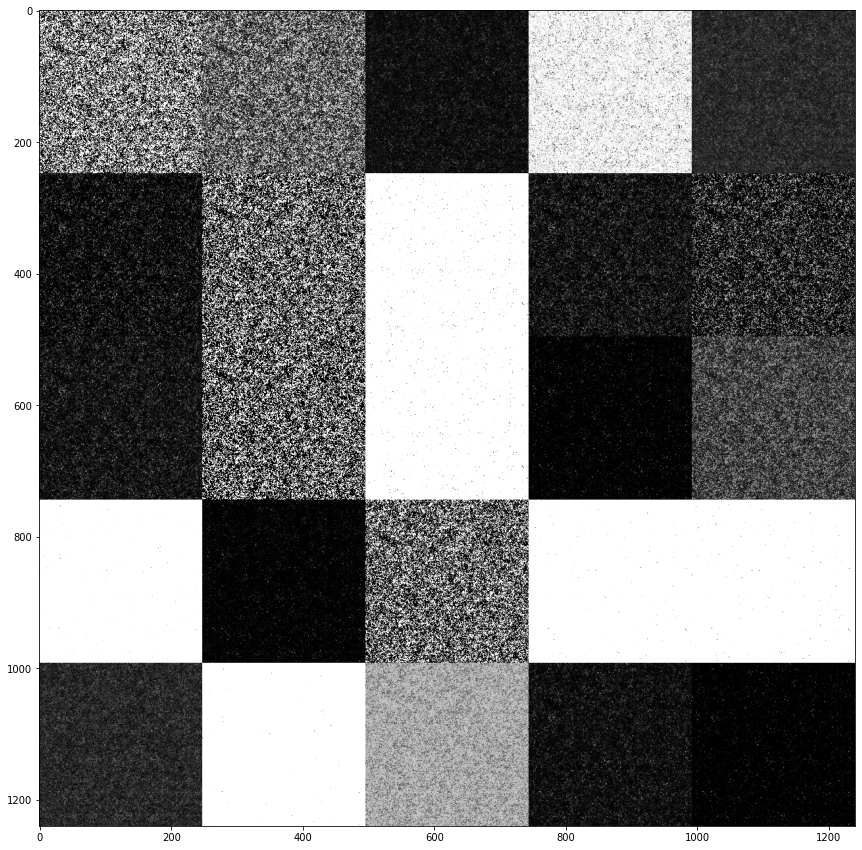

In [32]:

G.eval()
plt.figure(figsize = (15,15))
plt.imshow(get_sample_image(G, n_noise), cmap='gray')


In [ ]:
# torch.save(D.state_dict(), 'D.pkl')
# torch.save(G.state_dict(), 'G.pkl')